In [1]:
from patsy import *
# 경고 무시
import warnings
warnings.simplefilter('ignore')

# 자주 사용하는 패키지를 임포트
import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import sklearn as sk
import pgmpy
import scipy.stats

# matplotlib 설정
mpl.use('Agg')

# seaborn 설정
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

%matplotlib inline

In [2]:
def make_nonlinear(seed=0):
    np.random.seed(seed)
    n_samples = 30
    X = np.sort(np.random.rand(n_samples))
    y = np.sin(2 * np.pi * X) + np.random.randn(n_samples) * 0.1
    X = X[:, np.newaxis]
    return (X, y)


X, y = make_nonlinear()
dfX = pd.DataFrame(X, columns=["x"])
dfX = sm.add_constant(dfX)
dfy = pd.DataFrame(y, columns=["y"])
df = pd.concat([dfX, dfy], axis=1)

In [3]:
model = sm.OLS.from_formula(
    "y ~ x + I(x**2) + I(x**3) + I(x**4) + I(x**5) + I(x**6) + I(x**7) + I(x**8) + I(x**9)", data=df)
result1 = model.fit()
result1.params

Intercept       -0.169863
x               25.735773
I(x ** 2)     -428.141684
I(x ** 3)     3866.723115
I(x ** 4)   -18340.939667
I(x ** 5)    49326.072553
I(x ** 6)   -78884.743085
I(x ** 7)    74538.645164
I(x ** 8)   -38453.132196
I(x ** 9)     8350.254987
dtype: float64

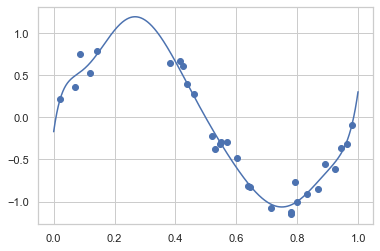

In [4]:
def plot_statsmodels(result):
    plt.scatter(X, y)
    xx = np.linspace(0, 1, 1000)
    dfxx = pd.DataFrame(xx, columns=["x"])
    dfxx = sm.add_constant(dfxx)
    plt.plot(xx, result.predict(dfxx).values)
    plt.show()


plot_statsmodels(result1)

[ 0.63308745 -0.75705866 -1.07056551 -0.76835135 -0.35530367  0.0121939
  0.29917825  0.50969248  0.65793698  0.75851865]


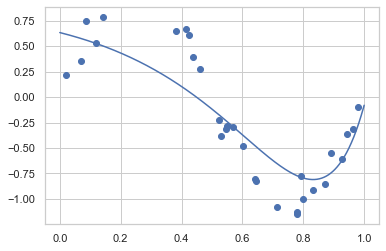

In [5]:
result2 = model.fit_regularized(alpha=0.01, L1_wt=0)
print(result2.params)
plot_statsmodels(result2)

Intercept    0.687949
x           -1.129134
I(x ** 2)   -1.124878
I(x ** 3)    0.000000
I(x ** 4)    0.000000
I(x ** 5)    0.000000
I(x ** 6)    0.000000
I(x ** 7)    0.000000
I(x ** 8)    0.281484
I(x ** 9)    1.075281
dtype: float64


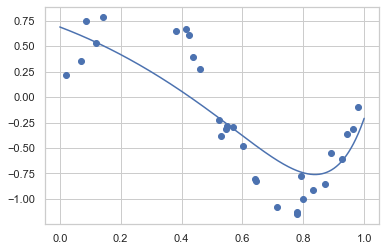

In [6]:
result3 = model.fit_regularized(alpha=0.01, L1_wt=1)
print(result3.params)
plot_statsmodels(result3)

Intercept    0.656203
x           -0.849745
I(x ** 2)   -1.262902
I(x ** 3)   -0.425687
I(x ** 4)    0.000000
I(x ** 5)    0.000000
I(x ** 6)    0.000000
I(x ** 7)    0.304049
I(x ** 8)    0.631908
I(x ** 9)    0.801206
dtype: float64


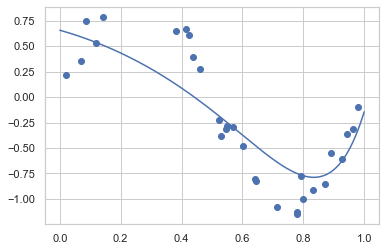

In [7]:
result4 = model.fit_regularized(alpha=0.01, L1_wt=0.5)
print(result4.params)
plot_statsmodels(result4)

In [9]:
def plot_sklearn(model):
    plt.scatter(X, y)
    xx = np.linspace(0, 1, 1000)
    plt.plot(xx, model.predict(xx[:, np.newaxis]))
    plt.show()

[ 0.00000000e+00  2.57357731e+01 -4.28141683e+02  3.86672311e+03
 -1.83409397e+04  4.93260725e+04 -7.88847431e+04  7.45386451e+04
 -3.84531322e+04  8.35025499e+03]


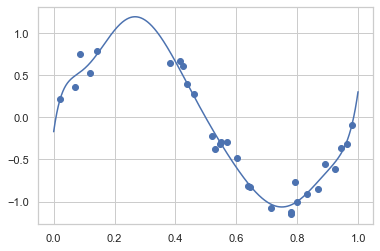

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

poly = PolynomialFeatures(9)
model = make_pipeline(poly, LinearRegression()).fit(X, y)
print(model.steps[1][1].coef_)
plot_sklearn(model)

[ 0.          1.51430399 -3.90160797 -2.6359859  -0.41526792  1.07530175
  1.64913273  1.52026782  0.94651401  0.13299614]


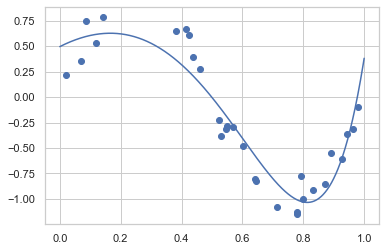

In [11]:
model = make_pipeline(poly, Ridge(alpha=0.01)).fit(X, y)
print(model.steps[1][1].coef_)
plot_sklearn(model)

[ 0.         -0.07668852 -2.44096313 -0.         -0.          0.
  0.          0.          0.          1.88188725]


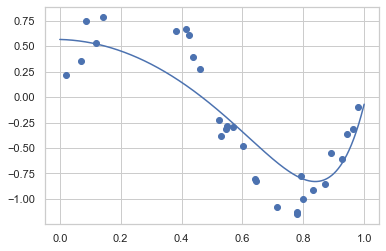

In [12]:
model = make_pipeline(poly, Lasso(alpha=0.01)).fit(X, y)
print(model.steps[1][1].coef_)
plot_sklearn(model)

[ 0.         -0.83768018 -1.23944649 -0.50166684 -0.          0.
  0.          0.30382246  0.62459231  0.84262899]


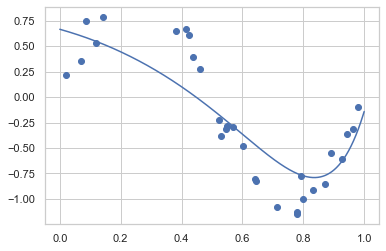

In [13]:
model = make_pipeline(poly, ElasticNet(alpha=0.01, l1_ratio=0.5)).fit(X, y)
print(model.steps[1][1].coef_)
plot_sklearn(model)

### Ridge 모형과 Lasso 모형의 차이

In [14]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

In [15]:
alpha = np.logspace(-3, 1, 5)

data = []
for i, a in enumerate(alpha):
    ridge = Ridge(alpha=a).fit(X, y)
    data.append(pd.Series(np.hstack([ridge.intercept_, ridge.coef_])))

df_ridge = pd.DataFrame(data, index=alpha).T
df_ridge

,0.001,0.010,0.100,1.000,10.000
0,152.133484,152.133484,152.133484,152.133484,152.133484
1,-9.551414,-7.199457,1.307349,29.465746,19.812822
2,-239.090354,-234.552930,-207.194814,-83.154885,-0.918458
3,520.363367,520.583136,489.691080,306.351627,75.416167
4,323.828627,320.523356,301.769437,201.629434,55.025419
5,-712.328205,-380.607066,-83.466074,5.909369,19.924600
6,413.383794,150.483752,-70.828096,-29.515927,13.948686
7,65.811629,-78.591232,-188.680164,-152.040465,-47.553816
8,167.513774,130.313059,115.712703,117.311715,48.259420
9,720.944468,592.349587,443.814054,262.944995,70.144068


In [16]:
alpha = np.logspace(-3, 1, 5)

data = []
for i, a in enumerate(alpha):
    lasso = Lasso(alpha=a).fit(X, y)
    data.append(pd.Series(np.hstack([lasso.intercept_, lasso.coef_])))

df_lasso = pd.DataFrame(data, index=alpha).T
df_lasso

,0.001,0.010,0.100,1.000,10.000
0,152.133484,152.133484,152.133484,152.133484,152.133484
1,-8.998449,-1.306575,-0.000000,0.000000,0.000000
2,-238.899740,-228.822331,-155.362882,-0.000000,0.000000
3,520.261362,525.560658,517.182017,367.701852,0.000000
4,323.429484,316.175320,275.082351,6.301904,0.000000
5,-720.251734,-307.013677,-52.540269,0.000000,0.000000
6,421.405141,89.321688,-0.000000,0.000000,0.000000
7,66.734168,-105.081398,-210.159753,-0.000000,-0.000000
8,164.448873,119.597989,0.000000,0.000000,0.000000
9,725.340440,571.330871,483.914409,307.605700,0.000000


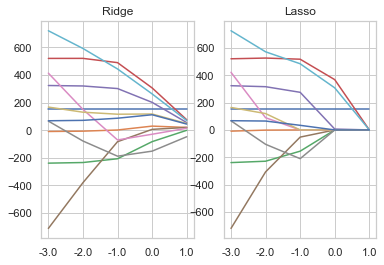

In [17]:
ax1 = plt.subplot(121)
plt.semilogx(df_ridge.T)
plt.xticks(alpha, labels=np.log10(alpha))
plt.title("Ridge")

ax2 = plt.subplot(122)
plt.semilogx(df_lasso.T)
plt.xticks(alpha, labels=np.log10(alpha))
plt.title("Lasso")

plt.show()

### 최적 정규화

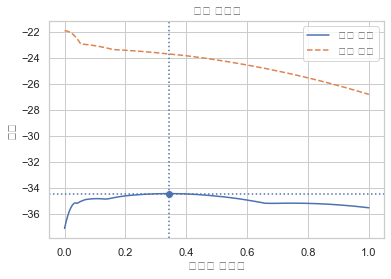

In [18]:
from sklearn.datasets import load_boston
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

boston = load_boston()
X = boston.data
y = boston.target

alphas = np.logspace(-4, 0, 200)

train_scores = []
test_scores = []
for alpha in alphas:
    model = Lasso(alpha=alpha)
    train_score = -mean_squared_error(y, model.fit(X, y).predict(X))
    test_score = np.mean(cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    train_scores.append(train_score)
    test_scores.append(test_score)

optimal_alpha = alphas[np.argmax(test_scores)]
optimal_score = np.max(test_scores)

plt.plot(alphas, test_scores, "-", label="검증 성능")
plt.plot(alphas, train_scores, "--", label="학습 성능")
plt.axhline(optimal_score, linestyle=':')
plt.axvline(optimal_alpha, linestyle=':')
plt.scatter(optimal_alpha, optimal_score)
plt.title("최적 정규화")
plt.ylabel('성능')
plt.xlabel('정규화 가중치')
plt.legend()
plt.show()

### 검증성능 곡선

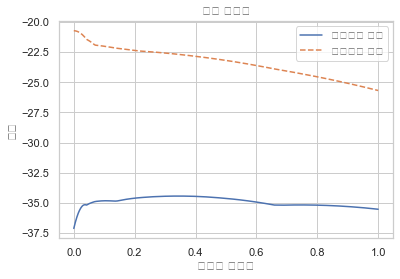

In [19]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = validation_curve(
    Lasso(), X, y, "alpha", alphas, cv=5,
    scoring="neg_mean_squared_error")

plt.plot(alphas, test_scores.mean(axis=1), "-", label="검증성능 평균")
plt.plot(alphas, train_scores.mean(axis=1), "--", label="학습성능 평균")
plt.ylabel('성능')
plt.xlabel('정규화 가중치')
plt.legend()
plt.title("최적 정규화")
plt.show()

### 다항회귀의 차수 결정

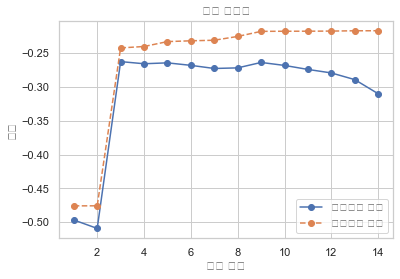

In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

n_samples = 100
np.random.seed(0)
X = np.sort(np.random.rand(n_samples))
y = np.sin(2 * np.pi * X) + np.random.randn(n_samples) * 0.5
X = X[:, np.newaxis]


model = Pipeline([("poly", PolynomialFeatures()),
                  ("lreg", LinearRegression())])

degrees = np.arange(1, 15)
train_scores, test_scores = validation_curve(
    model, X, y, "poly__degree", degrees, cv=100,
    scoring="neg_mean_squared_error")

plt.plot(degrees, test_scores.mean(axis=1), "o-", label="검증성능 평균")
plt.plot(degrees, train_scores.mean(axis=1), "o--", label="학습성능 평균")
plt.ylabel('성능')
plt.xlabel('다항 차수')
plt.legend()
plt.title("최적 정규화")
plt.show()